In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids

# Exploring the data

In [18]:
X_train_emb = np.load('X_train_emb.npy')
y_train = np.load('y_train.npy')
X_test_emb = np.load('X_test_emb.npy')

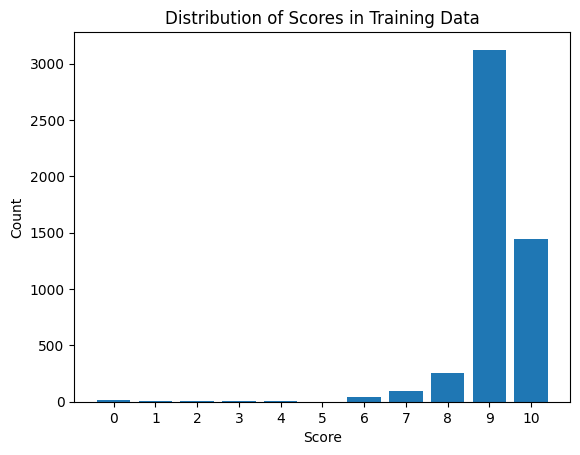

In [6]:
unique, counts = np.unique(np.round(y_train), return_counts=True)
# Bar graphs for counts
plt.bar(unique, counts)
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(unique)
plt.title('Distribution of Scores in Training Data')
plt.show()

<Axes: >

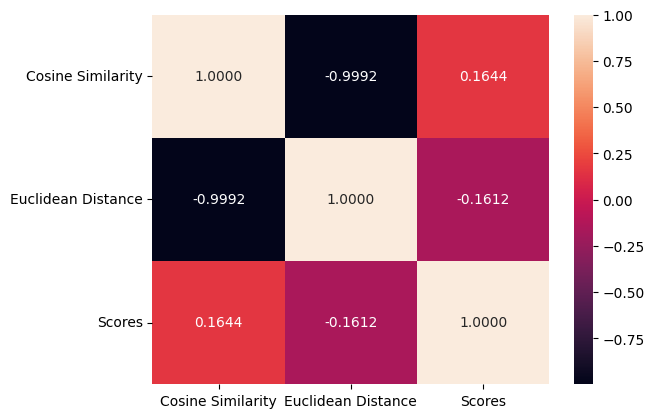

In [17]:
X_cos = np.zeros(len(X_train_emb))
X_dist = np.zeros(len(X_train_emb))
D = int(X_train_emb.shape[1]/2)
for i in range(len(X_train_emb)):
    X_cos[i] = np.dot(X_train_emb[i, :D], X_train_emb[i, D:])
    X_dist[i] = np.linalg.norm(X_train_emb[i, :D] - X_train_emb[i, D:])

#Heatmap of correlation between X_cos, X_dist and y_train
correlation_matrix = np.corrcoef(np.vstack((X_cos, X_dist, y_train)))
#Annotations upto 4 decimal places
sns.heatmap(correlation_matrix, annot=True, fmt=".4f", xticklabels=['Cosine Similarity', 'Euclidean Distance', 'Scores'], yticklabels=['Cosine Similarity', 'Euclidean Distance', 'Scores'])




# Baseline

In [20]:
def predict_constant(X):
    return 5*np.ones(X.shape[0])

y_train_const_pred = predict_constant(X_train_emb)
rmse_train_const = root_mean_squared_error(y_train, y_train_const_pred)
print(f'Constant Model - Train RMSE: {rmse_train_const:.4f}')
y_test_const_pred = predict_constant(X_test_emb)

Constant Model - Train RMSE: 4.2259


In [ ]:
with open('const_score.csv', 'w') as f:
    f.write('Id,Score\n')
    for i in range(len(y_test_const_pred)):
        f.write(f'{i},{int(y_test_const_pred[i])}\n')

# Two Model Approach

In [ ]:
#Separate models for data with low and high scores
low_indices = np.where(y_train <= 7)[0]
high_indices = np.where(y_train >= 7)[0]
model_low = RandomForestRegressor(n_estimators=100, random_state=42)
model_low.fit(X_train_emb[low_indices], y_train[low_indices])
model_high = RandomForestRegressor(n_estimators=100, random_state=42)
model_high.fit(X_train_emb[high_indices], y_train[high_indices])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
#Final prediction from the two models
def predict(X):
    pred_low = model_low.predict(X)
    pred_high = model_high.predict(X)
    y_pred = np.zeros_like(pred_low)
    for i in range(len(X)):
        if pred_low[i] <= 6:
            y_pred[i] = pred_low[i]
        elif pred_high[i] >= 9:
            y_pred[i] = pred_high[i]
        else:
            y_pred[i] = (pred_low[i] + pred_high[i]) / 2
    return y_pred


In [119]:
y_train_pred = predict(X_train_emb)
print("Train RMSE:", np.sqrt(root_mean_squared_error(y_train, y_train_pred)))

Train RMSE: 1.6268785560881072


In [ ]:
y_test_pred = predict(X_test_emb)
y_test_pred_int = np.round(y_test_pred).astype(int)

In [97]:
with open('two_model_simple_decimal.csv', 'w') as f:
    f.write('ID,score\n')
    for i, pred in enumerate(y_test_pred):
        f.write(f'{i+1},{pred}\n')

In [ ]:
with open('two_model_simple_integer.csv', 'w') as f:
    f.write('ID,score\n')
    for i, pred in enumerate(y_test_pred_int):
        f.write(f'{i+1},{pred}\n')